In [1]:
#using Pkg; Pkg.rm("FastJet"); Pkg.add("FastJet")
using LaTeXStrings
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using StatsPlots
using LinearAlgebra
using Corpuscles
#gr()
#theme(:gruvbox_dark)

In [ ]:
#using Pkg; Pkg.build("FastJet")
#using Pkg; Pkg.build("LCIO")

Set A: 
Processes: Pmumuh2bb, Pmumuh2cc, Pmumuh2gg
"0_DST" > ".*_DST"

In [2]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

#can use a sort function where the key to sort on is dot(p, p)

leadingParticleIndex (generic function with 1 method)

In [ ]:
#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

Strange Events

In [45]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\.0_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_ss[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [46]:
ss_MCleadPDG = []
ss_MCleadingParticlePList = []
ss_PFOleadPDG = []
ss_PFOleadingParticlePList = []
ss_kShortInPiPiEventList_MC = []
ss_kShortInPiPiEventList_PFO = []
ss_lambdaInProtonEventList_MC = []
ss_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_ss
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(ss_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(ss_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(ss_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            #大家好，如果你会读懂，我想告诉你很重要的事：加油！
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(ss_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(ss_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(ss_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

Produce figure with MC Particle and Pandora PFO breakdown for all 4 event types\
-Remove muon from everything\
-2 jets\
-Check if theres a K short in the pi pi highest particle events\
-If proton, check if lambda 0\
-just make a dictionary where name maps to value\
Run Z reco over MCParticle & PandoraPFO, compare

["γ", "K⁺", "π⁻", "Kₗ⁰", "π⁺", "p", "K⁻", "n", "̄{p}", "̄{n}"]

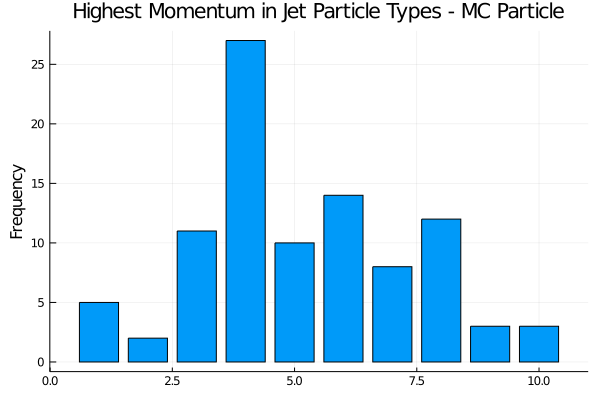

In [47]:
ss_MC_y=ss_MCleadPDG
ss_MC_u=sort(unique(ss_MC_y))
ss_MC_d=Dict([(i,count(x->x==i,ss_MC_y)) for i in ss_MC_u])
ss_MC_vals = [ss_MC_d[i] for i in ss_MC_u]
ss_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in ss_MC_u])
ss_MC_latex = [(ss_MC_Names[convert(Int32, i)]) for i in ss_MC_u]
ss_MC_printed_latex=["\\gamma", "K^{+}", "\\pi^{-}", "K_{L}^{0}", "\\pi^{+}", "p", "K^{-}", "n", "\\bar{p}", "\\bar{n}"]
ss_MC_edit_latex=["\\gamma", "K^{+}", "\\pi^{-}", "K_{l}^{0}", "\\pi^{+}", "p", "K^{-}", "n", "\\bar{p}", "\\bar{n}"]
ss_MC_x_axis_names=[to_latex(ss_MC_edit_latex[i]) for i in 1:length(ss_MC_edit_latex)]
print(ss_MC_x_axis_names)
StatsPlots.bar(ss_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_MC_u[i])" for i in 1:length(ss_MC_u)]

#StatsPlots.savefig("ss_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["e⁻", "K⁺", "Kₛ⁰", "γ", "π⁻", "Kₗ⁰", "p", "π⁺", "Λ", "K⁻", "̄{Λ}", "̄{p}", "̄{Σ}⁺", "Σ⁻"]

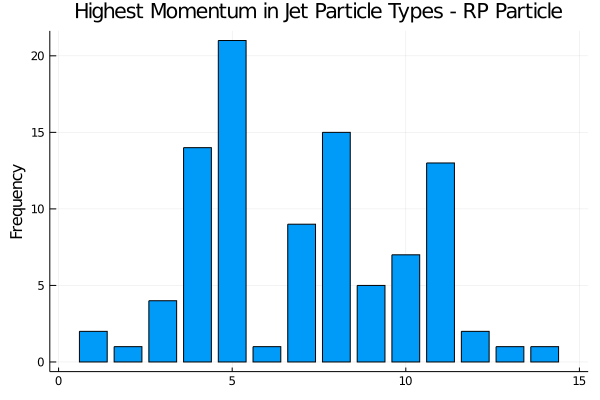

In [48]:
ss_RP_y=ss_PFOleadPDG
ss_RP_u=sort(unique(ss_RP_y))
ss_RP_d=Dict([(i,count(x->x==i,ss_RP_y)) for i in ss_RP_u])
ss_RP_vals = [ss_RP_d[i] for i in ss_RP_u]
ss_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in ss_RP_u])
ss_RP_latex = [(ss_RP_Names[convert(Int32, i)]) for i in ss_RP_u]
ss_RP_printed_latex=["e^{-}", "K^{+}", "K_{S}^{0}", "\\gamma", "\\pi^{-}", "K_{L}^{0}", "p", "\\pi^{+}", "\\Lambda", "K^{-}", "\\bar{\\Lambda}", "\\bar{p}", "\\bar{\\Sigma}^{+}", "\\Sigma^{-}"]
ss_RP_edit_latex=["e^{-}", "K^{+}", "K_{s}^{0}", "\\gamma", "\\pi^{-}", "K_{l}^{0}", "p", "\\pi^{+}", "\\Lambda", "K^{-}", "\\bar{\\Lambda}", "\\bar{p}", "\\bar{\\Sigma}^{+}", "\\Sigma^{-}"]
ss_RP_x_axis_names=[to_latex(ss_RP_edit_latex[i]) for i in 1:length(ss_RP_edit_latex)]
print(ss_RP_x_axis_names)
StatsPlots.bar(ss_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(ss_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_RP_u[i])" for i in 1:length(ss_RP_u)]

#StatsPlots.savefig("ss_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, botton events

In [8]:
fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_bb[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [9]:
bb_MCleadPDG = []
bb_MCleadingParticlePList = []
bb_PFOleadPDG = []
bb_PFOleadingParticlePList = []
bb_kShortInPiPiEventList_MC = []
bb_kShortInPiPiEventList_PFO = []
bb_lambdaInProtonEventList_MC = []
bb_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_bb
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            if iEvent>100
                break
            end
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(bb_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(bb_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(bb_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(bb_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(bb_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(bb_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "νₜₐᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

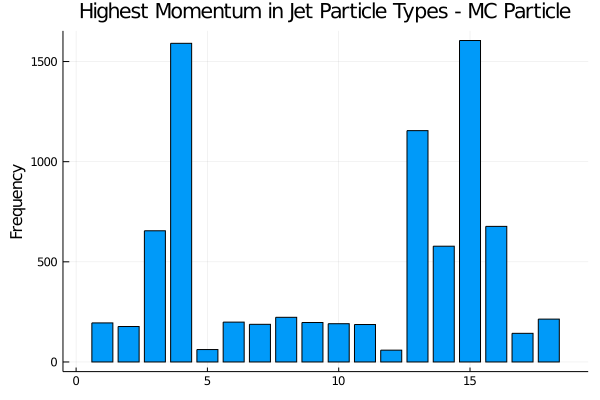

In [16]:
bb_MC_y=bb_MCleadPDG
bb_MC_u=sort(unique(bb_MC_y))
bb_MC_d=Dict([(i,count(x->x==i,bb_MC_y)) for i in bb_MC_u])
bb_MC_vals = [bb_MC_d[i] for i in bb_MC_u]
bb_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in bb_MC_u])
bb_MC_latex = [(bb_MC_Names[convert(Int32, i)]) for i in bb_MC_u]
bb_MC_printed_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{\\tau}", "\\bar{\\nu}_{\\mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{\\mu}", "\\nu_{\\tau}", "\\gamma", "K_{L}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
bb_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\nu_{tau}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
bb_MC_x_axis_names=[to_latex(bb_MC_edit_latex[i]) for i in 1:length(bb_MC_edit_latex)]
print(bb_MC_x_axis_names)
StatsPlots.bar(bb_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(bb_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(bb_MC_u[i])" for i in 1:length(bb_MC_u)]

#StatsPlots.savefig("bb_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["̄{Ξ}⁰", "̄{Ξ}⁺", "̄{Σ}⁻", "̄{Λ}", "̄{Σ}⁺", "̄{p}", "̄{n}", "K⁻", "π⁻", "e⁺", "e⁻", "γ", "Kₗ⁰", "π⁺", "Kₛ⁰", "K⁺", "n", "p", "Σ⁻", "Λ", "Σ⁺", "Ξ⁻", "Ξ⁰"]

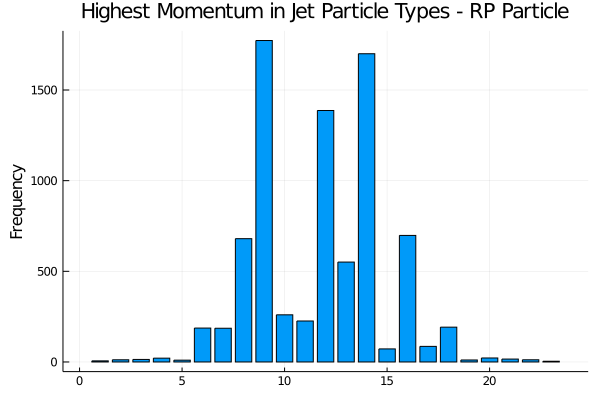

In [21]:
bb_RP_y=bb_PFOleadPDG
bb_RP_u=sort(unique(bb_RP_y))
bb_RP_d=Dict([(i,count(x->x==i,bb_RP_y)) for i in bb_RP_u])
bb_RP_vals = [bb_RP_d[i] for i in bb_RP_u]
bb_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in bb_RP_u])
bb_RP_latex = [(bb_RP_Names[convert(Int32, i)]) for i in bb_RP_u]
bb_RP_printed_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{L}^{0}", "\\pi^{+}", "K_{S}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
bb_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
bb_RP_x_axis_names=[to_latex(bb_RP_edit_latex[i]) for i in 1:length(bb_RP_edit_latex)]
print(bb_RP_x_axis_names)
StatsPlots.bar(bb_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(bb_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(bb_RP_u[i])" for i in 1:length(bb_RP_u)]

#StatsPlots.savefig("bb_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, charm events

In [22]:
fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_cc[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [23]:
cc_MCleadPDG = []
cc_MCleadingParticlePList = []
cc_PFOleadPDG = []
cc_PFOleadingParticlePList = []
cc_kShortInPiPiEventList_MC = []
cc_kShortInPiPiEventList_PFO = []
cc_lambdaInProtonEventList_MC = []
cc_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_cc
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(cc_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(cc_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(cc_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(cc_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(cc_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(cc_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "νₜₐᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

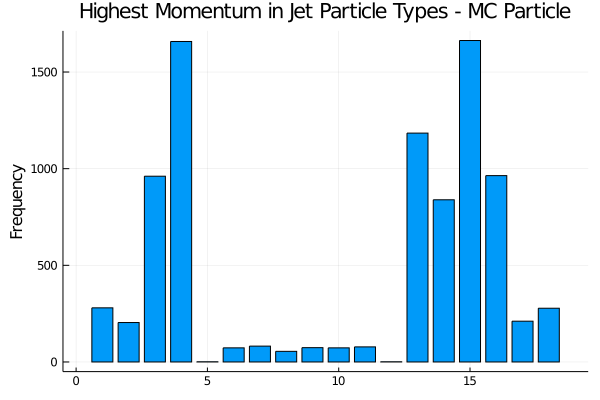

In [28]:
cc_MC_y=cc_MCleadPDG
cc_MC_u=sort(unique(cc_MC_y))
cc_MC_d=Dict([(i,count(x->x==i,cc_MC_y)) for i in cc_MC_u])
cc_MC_vals = [cc_MC_d[i] for i in cc_MC_u]
cc_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in cc_MC_u])
cc_MC_latex = [(cc_MC_Names[convert(Int32, i)]) for i in cc_MC_u]
cc_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\nu_{tau}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
cc_MC_x_axis_names=[to_latex(cc_MC_edit_latex[i]) for i in 1:length(cc_MC_edit_latex)]
print(cc_MC_x_axis_names)
StatsPlots.bar(cc_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(cc_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(cc_MC_u[i])" for i in 1:length(cc_MC_u)]

#StatsPlots.savefig("cc_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["̄{Ξ}⁰", "̄{Ξ}⁺", "̄{Σ}⁻", "̄{Λ}", "̄{Σ}⁺", "̄{p}", "̄{n}", "K⁻", "π⁻", "e⁺", "e⁻", "γ", "Kₗ⁰", "π⁺", "Kₛ⁰", "K⁺", "n", "p", "Σ⁻", "Λ", "Σ⁺", "Ξ⁻", "Ξ⁰"]

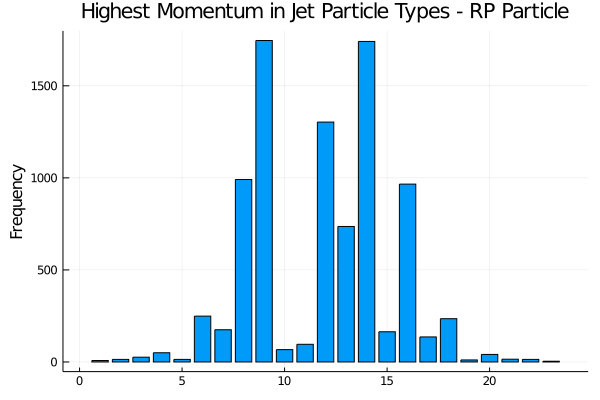

In [32]:
cc_RP_y=cc_PFOleadPDG
cc_RP_u=sort(unique(cc_RP_y))
cc_RP_d=Dict([(i,count(x->x==i,cc_RP_y)) for i in cc_RP_u])
cc_RP_vals = [cc_RP_d[i] for i in cc_RP_u]
cc_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in cc_RP_u])
cc_RP_latex = [(cc_RP_Names[convert(Int32, i)]) for i in cc_RP_u]
cc_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
cc_RP_x_axis_names=[to_latex(cc_RP_edit_latex[i]) for i in 1:length(cc_RP_edit_latex)]
print(cc_RP_x_axis_names)
StatsPlots.bar(cc_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(cc_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(cc_RP_u[i])" for i in 1:length(cc_RP_u)]

#StatsPlots.savefig("cc_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, gluon events

In [37]:
fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_gg[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [38]:
gg_MCleadPDG = []
gg_MCleadingParticlePList = []
gg_PFOleadPDG = []
gg_PFOleadingParticlePList = []
gg_kShortInPiPiEventList_MC = []
gg_kShortInPiPiEventList_PFO = []
gg_lambdaInProtonEventList_MC = []
gg_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_gg
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(gg_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(gg_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(gg_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(gg_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(gg_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(gg_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

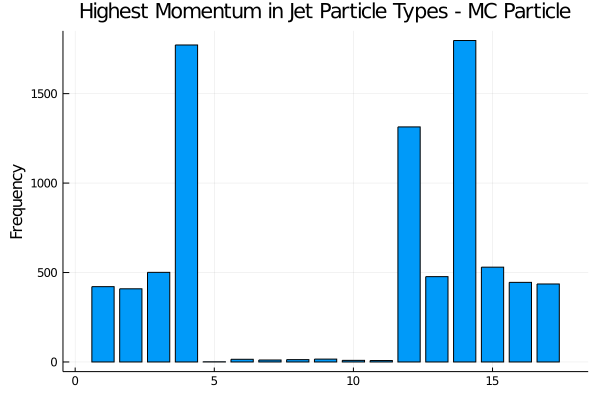

In [42]:
gg_MC_y=gg_MCleadPDG
gg_MC_u=sort(unique(gg_MC_y))
gg_MC_d=Dict([(i,count(x->x==i,gg_MC_y)) for i in gg_MC_u])
gg_MC_vals = [gg_MC_d[i] for i in gg_MC_u]
gg_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in gg_MC_u])
gg_MC_latex = [(gg_MC_Names[convert(Int32, i)]) for i in gg_MC_u]
gg_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
gg_MC_x_axis_names=[to_latex(gg_MC_edit_latex[i]) for i in 1:length(gg_MC_edit_latex)]
print(gg_MC_x_axis_names)
StatsPlots.bar(gg_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(gg_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(gg_MC_u[i])" for i in 1:length(gg_MC_u)]

#StatsPlots.savefig("gg_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["̄{Ξ}⁰", "̄{Ξ}⁺", "̄{Σ}⁻", "̄{Lambda}", "̄{Σ}⁺", "̄{p}", "̄{n}", "K⁻", "π⁻", "e⁺", "e⁻", "νₘᵤ", "γ", "Kₗ⁰", "π⁺", "Kₛ⁰", "K⁺", "n", "p", "Σ⁻", "Λ", "Σ⁺", "Ξ⁻", "Ξ⁰"]

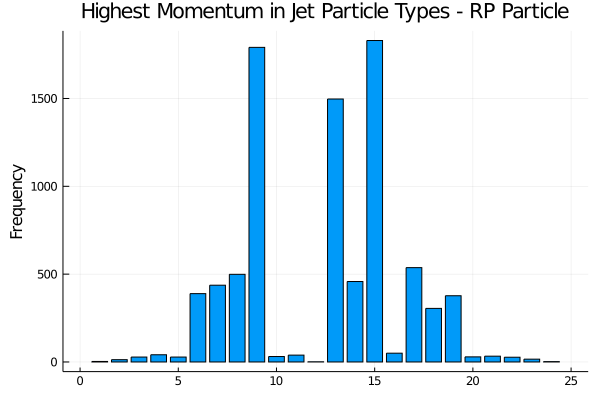

In [43]:
gg_RP_y=gg_PFOleadPDG
gg_RP_u=sort(unique(gg_RP_y))
gg_RP_d=Dict([(i,count(x->x==i,gg_RP_y)) for i in gg_RP_u])
gg_RP_vals = [gg_RP_d[i] for i in gg_RP_u]
gg_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in gg_RP_u])
gg_RP_latex = [(gg_RP_Names[convert(Int32, i)]) for i in gg_RP_u]
gg_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\nu_{mu}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
gg_RP_x_axis_names=[to_latex(gg_RP_edit_latex[i]) for i in 1:length(gg_RP_edit_latex)]
print(gg_RP_x_axis_names)
StatsPlots.bar(gg_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(gg_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(gg_RP_u[i])" for i in 1:length(gg_RP_u)]

#StatsPlots.savefig("gg_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

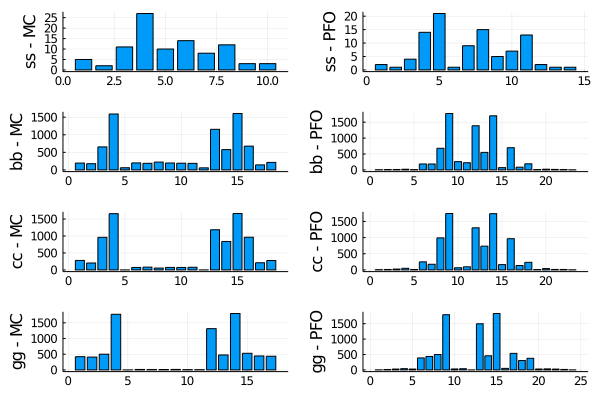

In [50]:
#plot(title="Lead Momentum Particle per Jet - MC Truth and Pandora PFO")
plot(
    StatsPlots.bar(ss_MC_vals, ylabel="ss - MC"),
    StatsPlots.bar(ss_RP_vals, ylabel="ss - PFO"),
    StatsPlots.bar(bb_MC_vals, ylabel="bb - MC"),
    StatsPlots.bar(bb_RP_vals, ylabel="bb - PFO"),
    StatsPlots.bar(cc_MC_vals, ylabel="cc - MC"),
    StatsPlots.bar(cc_RP_vals, ylabel="cc - PFO"),
    StatsPlots.bar(gg_MC_vals, ylabel="gg - MC"),
    StatsPlots.bar(gg_RP_vals, ylabel="gg - PFO"),
    layout=(4,2),
    legend=false,
    )